### Libraries

In [1]:
import networkx as nx
from shapely.geometry import Point,LineString,Polygon

import simpy
import xarray as xr

from opentnsim import core as core_module
from opentnsim import graph as graph_module
from opentnsim import lock_new as lock_module
from opentnsim import energy as energy_module
from opentnsim import output as output_module
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module
from opentnsim import zeesluisformulering as ZSF
from netCDF4 import Dataset
import datetime
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.dates as mdates
import folium
from shapely.ops import nearest_points, linemerge, split, snap, transform
import pyproj
import re
path = os.getcwd()

In [2]:
%load_ext autoreload
%autoreload 2

path = os.getcwd()

### Simulation

In [3]:
env = simpy.Environment()
t_start = datetime.datetime(2025, 1, 1, 0, 0, 0)
t_stop = datetime.datetime(2026, 1, 1, 0, 0, 0)

env = simpy.Environment(initial_time=t_start.timestamp())
env.epoch = t_start
env.simulation_start = t_start
env.simulation_stop = t_stop

### Network

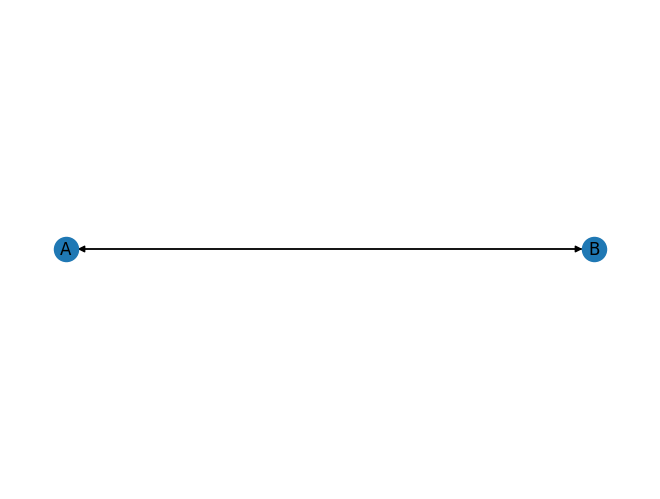

In [4]:
wgs84eqd = pyproj.CRS('4087')
wgs84rad = pyproj.CRS('4326')
wgs84eqd_to_wgs84rad = pyproj.transformer.Transformer.from_crs(wgs84eqd,wgs84rad,always_xy=True).transform
wgs84rad_to_wgs84eqd = pyproj.transformer.Transformer.from_crs(wgs84rad,wgs84eqd,always_xy=True).transform

graph = nx.MultiDiGraph()
graph.add_node('A',geometry=transform(wgs84eqd_to_wgs84rad,Point(-5000,0)))
graph.add_node('B',geometry=transform(wgs84eqd_to_wgs84rad,Point(5000,0)))
graph.add_edge('A','B',geometry=transform(wgs84eqd_to_wgs84rad,LineString([Point(-5000,0),Point(5000,0)])),length=10000)
graph.add_edge('B','A',geometry=transform(wgs84eqd_to_wgs84rad,LineString([Point(5000,0),Point(-5000,0)])),length=10000)
pos = {edge:(point.x,point.y) for edge,point in nx.get_node_attributes(graph, 'geometry').items()}
nx.draw(graph,pos,with_labels=True)
env.FG = graph

### Hydrodynamics

In [5]:
if "hydrodynamic_data_test.nc" not in os.listdir(path+"\\hydrodynamic_data\\"):
    hydrodynamic_data = xr.Dataset()
    times = np.arange(pd.Timestamp('2025-01-01 00:00'),pd.Timestamp('2026-01-01 00:00'),pd.Timedelta(5,'min'))
    nodes = np.array(['A','B'])
    wlevs = np.array([np.array([np.sin((2*np.pi/(12.5*60*60))*x) for x in np.arange(0,365*24*60*60,5*60)]),np.zeros(len(times))])
    salinity = np.array([30*np.ones(len(times)),np.zeros(len(times))])
    wlev_data = xr.DataArray(data=wlevs,coords={'STATION':nodes,'TIME':times})
    salinity_data = xr.DataArray(data=salinity,coords={'STATION':nodes,'TIME':times})
    hydrodynamic_data['Water level'] = wlev_data
    hydrodynamic_data['Salinity'] = salinity_data
    hydrodynamic_data.to_netcdf(path+"\\hydrodynamic_data\\hydrodynamic_data_test.nc")

### Vessel speed

In [6]:
if "speed_test.pkl" not in os.listdir(path+"\\hydrodynamic_data\\"):
    edge_index = [('A','B',0),('B','A',0)]
    data = np.array([4,4])
    vessel_speed_data = pd.DataFrame(data=data,columns=['Speed'],index=edge_index)
    vessel_speed_data.to_pickle(path + '\\speed_test.pkl')
else:
    vessel_speed_data = pickle.read(open(path + '\\speed_test.pkl','rb'))

### Vessel traffic services

In [7]:
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(FG=graph, 
                                                                                hydrodynamic_start_time = pd.Timestamp('2025-01-01 00:00'),
                                                                                hydrodynamic_information_path = path+"\\hydrodynamic_data\\hydrodynamic_data_test.nc", 
                                                                                vessel_speed_data_path = path + '\\speed_test.pkl')

### Lock object

In [8]:
lock = lock_module.IsLockComplex(env=env,
                                 name='Lock',
                                 start_node='A',
                                 node_open='A',
                                 end_node='B',
                                 approach_node_A = 'A',
                                 approach_node_B = 'B',
                                 distance_lock_doors_A_to_waiting_area_A = 4900,
                                 distance_lock_doors_B_to_waiting_area_B = 4900,
                                 distance_from_start_node_to_lock_doors_A = 4900,
                                 distance_from_end_node_to_lock_doors_B = 4900,
                                 lock_length = 200,
                                 lock_width = 30,
                                 lock_depth = 15,
                                 levelling_time = 300,
                                 #disch_coeff = 0.65,
                                 #gate_opening_time = 120,
                                 #opening_area = 80,
                                 P_used_to_break_before_lock=0.001,
                                 sailing_distance_to_crossing_point = 1900,
                                 doors_opening_time= 300,
                                 doors_closing_time= 300,
                                 speed_reduction_factor_lock_chamber=1.5,
                                 sailing_in_time_gap = 300,
                                 sailing_in_speed = 1.5,
                                 sailing_out_speed = 1.5,
                                 sailing_out_time_gap = 120,
                                 time_step = 30,
                                 sailing_time_before_opening_lock_doors = 600,
                                 sailing_time_before_closing_lock_doors = 60,
                                 detector_nodes = ['A','B'],
                                 predictive=False)

### Vessels

In [9]:
Vessel = type('Vessel',(energy_module.ConsumesEnergy,lock_module.PassesLockComplex,vessel_module.IsVessel,),{}) 

In [10]:
vessel_1 = Vessel(**{"env": env,
                     "name": 'Vessel 1',
                     "origin": 'A',
                     "destination": 'B',
                     "type": 'tanker',
                     "bound": 'outbound',
                     "L": 100,
                     "B": 20,
                     "T": 10,
                     "v": 4,
                     "P_installed": 50000*1000,
                     "C_year": 2010,
                     "L_w":3,
                     "arrival_time": pd.Timestamp('2025-01-01 00:00:00')})
vessel_1.process = env.process(vessel_1.move())

# vessel_2 = Vessel(**{"env": env,
#                      "name": 'Vessel 2',
#                      "origin": 'B',
#                      "destination": 'A',
#                      "type": 'tanker',
#                      "bound": 'outbound',
#                      "L": 100,
#                      "B": 20,
#                      "T": 10,
#                      "v": 4,
#                      "P_installed": 50000*1000,
#                      "C_year": 2010,
#                      "L_w":3,
#                      "C_year": 2010,
#                      "arrival_time": pd.Timestamp('2025-01-01 00:05:00')})
# vessel_2.process = env.process(vessel_2.move())

# vessel_3 = Vessel(**{"env": env,
#                      "name": 'Vessel 3',
#                      "origin": 'A',
#                      "destination": 'B',
#                      "type": 'tanker',
#                      "bound": 'inbound',
#                      "L": 100,
#                      "B": 20,
#                      "T": 10,
#                      "v": 4,
#                      "P_installed": 50000*1000,
#                      "C_year": 2010,
#                      "L_w":3,
#                      "arrival_time": pd.Timestamp('2025-01-01 00:10:00')})
# vessel_3.process = env.process(vessel_3.move())

# vessel_4 = Vessel(**{"env": env,
#                      "name": 'Vessel 4',
#                      "origin": 'A',
#                      "destination": 'B',
#                      "type": 'tanker',
#                      "bound": 'inbound',
#                      "L": 100,
#                      "B": 20,
#                      "T": 10,
#                      "v": 4,
#                      "P_installed": 50000*1000,
#                      "C_year": 2010,
#                      "L_w":3,
#                      "arrival_time": pd.Timestamp('2025-01-01 00:15:00')})
# vessel_4.process = env.process(vessel_4.move())

# vessel_5 = Vessel(**{"env": env,
#                      "name": 'Vessel 5',
#                      "origin": 'A',
#                      "destination": 'B',
#                      "type": 'tanker',
#                      "bound": 'inbound',
#                      "L": 100,
#                      "B": 20,
#                      "T": 10,
#                      "v": 4,
#                      "P_installed": 50000*1000,
#                      "C_year": 2010,
#                      "L_w":3,
#                      "arrival_time": pd.Timestamp('2025-01-01 00:12:00')})
# vessel_5.process = env.process(vessel_5.move())

vessels = []
vessels.append(vessel_1)
# vessels.append(vessel_2)
# vessels.append(vessel_3)
# vessels.append(vessel_4)
# vessels.append(vessel_5)

### Run model

In [11]:
env.run()

vessel_passing_start_timestamp 2025-01-01 00:12:30
lock_operation_start_time 2025-01-01 00:12:30
lock_entry_start_time 0 days 00:10:56.018512097
lock_door_opening_time 0 days 00:00:27.324256749
vessel_entry_stop_time 0 days 00:13:00.855469988
lock_entry_stop_time 0 days 00:13:00.855469988
delaychino 150.0 1.5
time_door_closing_start 2025-01-01 00:25:30.855469988
delaychino 50.0 1.5
time_door_closing_start 2025-01-01 00:25:30.855469988 2025-01-01 00:23:26.018512097 2025-01-01 00:25:30.855469988 0 days 00:01:33.333333333
departure_start_time 0 days 00:00:00
time_departure_start hi ha ho 0 days 00:00:00
yo yo yo yo
departure_start_time 0 days 00:00:00
sailing_out_time 0 days 00:00:38.142657371 50.0 1.310868288839632
time_departure_stop 0 days 00:00:38.142657371 0 days 00:00:00 0 days 00:00:38.142657371
hellup 2025-01-01 00:41:08.998127359
departure_start_time 0 days 00:00:00
sailing_out_time 0 days 00:00:38.142657371 50.0 1.310868288839632
time_departure_stop 0 days 00:00:38.142657371 0 d

In [12]:
vessel_df = pd.DataFrame(vessel_1.logbook)
vessel_df

,Message,Timestamp,Value,Geometry
0,Sailing from node A to node B start,2025-01-01 00:00:00.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-0.0449157642059761 0)
1,Sailing to first lock doors start,2025-01-01 00:00:00.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-0.0449157642059761 0)
2,Sailing to first lock doors stop,2025-01-01 00:23:26.018512,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-0.0008983152841195 0)
3,Sailing to position in lock start,2025-01-01 00:23:26.018512,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-0.0008983152841195 0)
4,Sailing to position in lock stop,2025-01-01 00:25:30.855470,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (0.0004491576420598 0)
5,Levelling start,2025-01-01 00:30:30.855470,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (0.0004491576420598 0)
6,Levelling stop,2025-01-01 00:35:30.855470,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (0.0004491576420598 0)
7,Sailing to second lock doors start,2025-01-01 00:40:30.855470,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (0.0004491576420598 0)
8,Sailing to second lock doors stop,2025-01-01 00:41:08.998127,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (0.0008983152841195 0)
9,Sailing to lock complex exit start,2025-01-01 00:41:08.998127,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (0.0008983152841195 0)


In [13]:
lock_df = pd.DataFrame(lock.logbook)
lock_df

,Message,Timestamp,Value,Geometry
0,Lock doors closing start,2025-01-01 00:25:30.855470,{},A
1,Lock doors closing stop,2025-01-01 00:30:30.855470,{},A
2,Lock chamber converting start,2025-01-01 00:30:30.855470,{},A
3,Lock chamber converting stop,2025-01-01 00:35:30.855470,{},B
4,Lock doors opening start,2025-01-01 00:35:30.855470,{},B
5,Lock doors opening stop,2025-01-01 00:40:30.855470,{},B


In [14]:
all_times = []
all_distances = []
lock_edge_geometry = transform(wgs84rad_to_wgs84eqd,graph.edges['A','B',0]['geometry'])
for vessel in vessels:
    times = []
    distances = []
    vessel_df = pd.DataFrame(vessel.logbook)
    vessel_df['Geometry'] = vessel_df['Geometry'].apply(lambda x: transform(wgs84rad_to_wgs84eqd,x))  
    for index,message_info in vessel_df.iterrows():
        time = message_info.Timestamp
        distance = lock_edge_geometry.line_locate_point(message_info.Geometry)-lock_edge_geometry.length/2
        origin = message_info.Value['origin']
        destination = message_info.Value['destination']
        edge_length = env.FG.edges[origin,destination,0]['length']
        direction = 0
        if origin != lock.start_node:
            direction = 1
        if message_info.Message == 'Sailing to first lock doors stop':   
            v0 = vessel_speed_data[vessel_speed_data.index == (origin,destination,0)].iloc[0].Speed
            v_target = lock.sailing_in_speed
            output = vessel.distance_to_desired_speed(v_target=v_target,P_used=lock.P_used_to_break_before_lock,h0=17,v0=v0)
            if not direction:
                distances_from_end = -1*(np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
            else:
                distances_from_end = (np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
            times.extend(times_slowing_down) 
            distances.extend(distances_slowing_down)
            times.append(time)
            distances.append(distance)
        elif message_info.Message == 'Sailing to position in lock stop':
            v0 = lock.sailing_in_speed
            v_target = 0.1
            output = vessel.distance_to_desired_speed(v_target=v_target,P_used=0.005,h0=lock.lock_depth,v0=v0)
            if not direction:
                distances_from_end = -1*(np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
            else:
                distances_from_end = (np.append(np.array(list(reversed(output['distance']))),np.array(0))-output['distance'][-1])
                distances_slowing_down = list(reversed(list(np.array(distance - distances_from_end))))
                times_slowing_down = list(reversed(list(time - np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']])))))
            times.extend(times_slowing_down) 
            distances.extend(distances_slowing_down)
            times.append(time)
            distances.append(distance)
        elif message_info.Message == 'Sailing to second lock doors start':
            times.append(time)
            distances.append(distance)
            v0 = 0.1
            v_target = lock.sailing_out_speed
            output = vessel.distance_to_desired_speed(v_target=v_target,P_used=0.02,h0=lock.lock_depth,v0=v0)
            if not direction:
                distances_from_start = np.append(np.array(0),np.array(output['distance']))
                distances_accelerating = distance+distances_from_start
                times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
            else:
                distances_from_start = -1*np.append(np.array(0),np.array(output['distance']))
                distances_accelerating = distance+distances_from_start
                times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
            times.extend(times_accelerating) 
            distances.extend(distances_accelerating)
        elif message_info.Message == 'Sailing to lock complex exit start':
            times.append(time)
            distances.append(distance)
            v0 = lock.sailing_out_speed
            v_target = vessel_speed_data[vessel_speed_data.index == (origin,destination,0)].iloc[0].Speed
            output = vessel.distance_to_desired_speed(v_target=v_target,P_used=0.02,h0=17,v0=v0)
            if not direction:
                distances_from_start = np.append(np.array(0),np.array(output['distance']))
                distances_accelerating = distance+distances_from_start
                times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
            else:
                distances_from_start = -1*np.append(np.array(0),np.array(output['distance']))
                distances_accelerating = distance+distances_from_start
                times_accelerating = time + np.append(np.array(pd.Timedelta(seconds=0)),np.array([pd.Timedelta(seconds=time) for time in output['time']]))
            times.extend(times_accelerating) 
            distances.extend(distances_accelerating)
        else:
            times.append(time)
            distances.append(distance)
            
    all_times.append(times)
    all_distances.append(distances)

In [15]:
v0 = 0.1
v_target = lock.sailing_out_speed
output = vessel.distance_to_desired_speed(v_target=v_target,P_used=0.01,h0=lock.lock_depth,v0=v0)

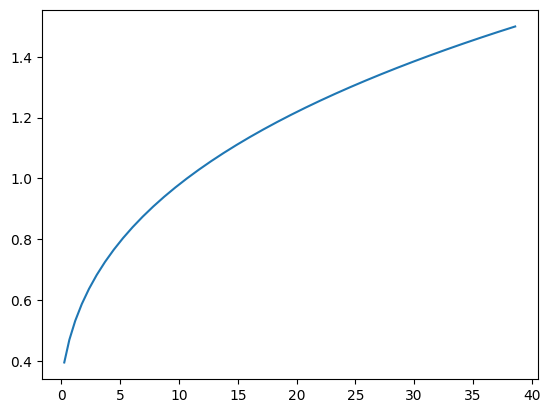

In [16]:
plt.plot(output['distance'],output['velocity'])

In [17]:
output = vessel.distance_to_desired_speed(v_target=v_target,P_used=0.02,h0=17,v0=v0)

In [18]:
vessel_df

,Message,Timestamp,Value,Geometry
0,Sailing from node A to node B start,2025-01-01 00:00:00.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-5000 0)
1,Sailing to first lock doors start,2025-01-01 00:00:00.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-5000 0)
2,Sailing to first lock doors stop,2025-01-01 00:23:26.018512,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-99.99999999999866 0)
3,Sailing to position in lock start,2025-01-01 00:23:26.018512,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-99.99999999999866 0)
4,Sailing to position in lock stop,2025-01-01 00:25:30.855470,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (50.00000000000126 0)
5,Levelling start,2025-01-01 00:30:30.855470,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (50.00000000000126 0)
6,Levelling stop,2025-01-01 00:35:30.855470,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (50.00000000000126 0)
7,Sailing to second lock doors start,2025-01-01 00:40:30.855470,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (50.00000000000126 0)
8,Sailing to second lock doors stop,2025-01-01 00:41:08.998127,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (99.99999999999866 0)
9,Sailing to lock complex exit start,2025-01-01 00:41:08.998127,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (99.99999999999866 0)


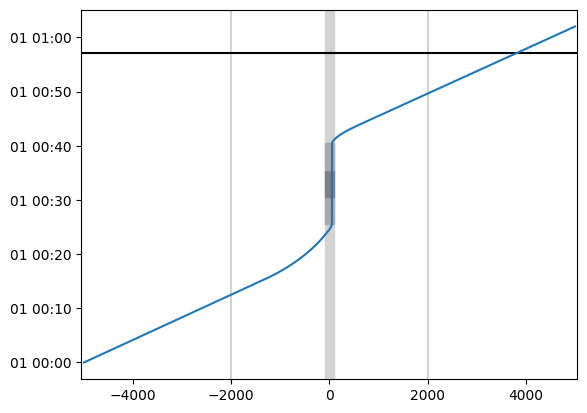

In [19]:
fig,ax = plt.subplots()

for distances,times in zip(all_distances,all_times):
    ax.plot(distances,times)

ylimmin,ylimmax = ax.get_ylim()

#Plot lock chamber
x_lock_doorsA = lock_edge_geometry.line_locate_point(transform(wgs84rad_to_wgs84eqd,lock.location_lock_doors_A))-lock_edge_geometry.length/2
x_lock_doorsB = lock_edge_geometry.line_locate_point(transform(wgs84rad_to_wgs84eqd,lock.location_lock_doors_B))-lock_edge_geometry.length/2
lock_extend_x = [x_lock_doorsA,x_lock_doorsA,x_lock_doorsB,x_lock_doorsB]
ax.fill(lock_extend_x,[ylimmin,ylimmax,ylimmax,ylimmin],color='lightgrey',zorder=0)

#Plot lock phases
for index, message_info in lock_df.iterrows():
    if message_info.Message == 'Lock doors opening stop' and index != 0:
        time_start = lock_df.loc[index-1,'Timestamp'] 
        time_stop = message_info.Timestamp
        ax.fill(lock_extend_x,[time_start,time_stop,time_stop,time_start],color='darkgrey',zorder=0)
    if message_info.Message == 'Lock doors closing stop' and index != 0:
        time_start = lock_df.loc[index-1,'Timestamp'] 
        time_stop = message_info.Timestamp
        ax.fill(lock_extend_x,[time_start,time_stop,time_stop,time_start],color='darkgrey',zorder=0)
    if message_info.Message == 'Lock chamber converting stop' and index != 0:
        time_start = lock_df.loc[index-1,'Timestamp'] 
        time_stop = message_info.Timestamp
        ax.fill(lock_extend_x,[time_start,time_stop,time_stop,time_start],color='grey',zorder=0)

ax.axvline(-2000,color='lightgrey',zorder=0)
ax.axvline(2000,color='lightgrey',zorder=0)
ax.axhline(pd.Timestamp('2025-01-01 00:57:01.188580063'),color='k',zorder=0)
ax.set_xlim(-5050,5050);
ax.set_ylim(ylimmin,ylimmax);

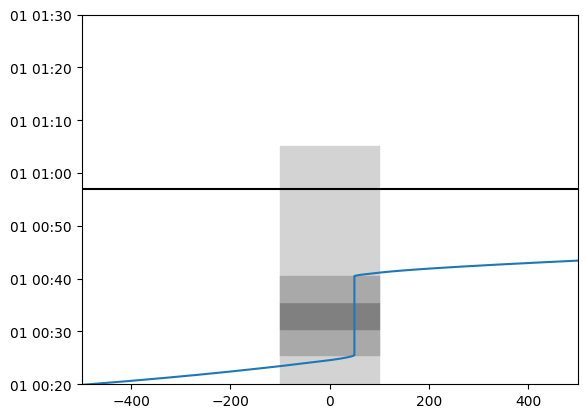

In [20]:
ax.set_xlim(-500,500)
ax.set_ylim(pd.Timestamp('2025-01-01 00:20'),pd.Timestamp('2025-01-01 01:30'))
fig

In [21]:
vessel_df

,Message,Timestamp,Value,Geometry
0,Sailing from node A to node B start,2025-01-01 00:00:00.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-5000 0)
1,Sailing to first lock doors start,2025-01-01 00:00:00.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-5000 0)
2,Sailing to first lock doors stop,2025-01-01 00:23:26.018512,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-99.99999999999866 0)
3,Sailing to position in lock start,2025-01-01 00:23:26.018512,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (-99.99999999999866 0)
4,Sailing to position in lock stop,2025-01-01 00:25:30.855470,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (50.00000000000126 0)
5,Levelling start,2025-01-01 00:30:30.855470,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (50.00000000000126 0)
6,Levelling stop,2025-01-01 00:35:30.855470,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (50.00000000000126 0)
7,Sailing to second lock doors start,2025-01-01 00:40:30.855470,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (50.00000000000126 0)
8,Sailing to second lock doors stop,2025-01-01 00:41:08.998127,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (99.99999999999866 0)
9,Sailing to lock complex exit start,2025-01-01 00:41:08.998127,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (99.99999999999866 0)


In [22]:
lock.vessel_planning.iloc[0]

bound                                                                 0
L                                                                   100
B                                                                    20
T                                                                    10
operation_index                                                       0
time_of_registration                                2025-01-01 00:00:00
time_of_acceptance                                  2025-01-01 00:00:00
time_arrival_at_waiting_area                        2025-01-01 00:00:00
time_arrival_at_lineup_area                                         NaN
time_lock_passing_start                             2025-01-01 00:12:30
time_lock_entry_start                     2025-01-01 00:23:26.018512097
time_lock_entry_stop                      2025-01-01 00:25:30.855469988
time_lock_departure_start                 2025-01-01 00:40:30.855469988
time_lock_departure_stop                  2025-01-01 00:41:08.99

In [23]:
lock_df

,Message,Timestamp,Value,Geometry
0,Lock doors closing start,2025-01-01 00:25:30.855470,{},A
1,Lock doors closing stop,2025-01-01 00:30:30.855470,{},A
2,Lock chamber converting start,2025-01-01 00:30:30.855470,{},A
3,Lock chamber converting stop,2025-01-01 00:35:30.855470,{},B
4,Lock doors opening start,2025-01-01 00:35:30.855470,{},B
5,Lock doors opening stop,2025-01-01 00:40:30.855470,{},B


In [24]:
lock.operation_planning.iloc[0]

bound                                                                                    0
vessels                                   [<__main__.Vessel object at 0x000002249AFA9150>]
capacity_L                                                                             100
capacity_B                                                                              10
time_potential_lock_door_opening_stop                        2025-01-01 00:12:57.324256749
time_operation_start                                                   2025-01-01 00:12:30
time_entry_start                                             2025-01-01 00:23:26.018512097
time_entry_stop                                              2025-01-01 00:25:30.855469988
time_door_closing_start                                      2025-01-01 00:25:30.855469988
time_door_closing_stop                                       2025-01-01 00:30:30.855469988
time_levelling_start                                         2025-01-01 00:30:30.855469988

In [25]:
#Testing time that vessel enters the lock
np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_entry_start.to_pydatetime().timestamp()/10,
                               vessel_df.loc[2].Timestamp.to_pydatetime().timestamp()/10,decimal=0)

#Testing time that vessel stops in the lock
np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_entry_stop.to_pydatetime().timestamp()/10,
                               vessel_df.loc[4].Timestamp.to_pydatetime().timestamp()/10,decimal=0)

# Testing time that lock door is closing start
np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_door_closing_start.to_pydatetime().timestamp()/10,
                               lock_df.loc[0].Timestamp.to_pydatetime().timestamp()/10,decimal=0)

# Testing time that lock door is closing stop
np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_door_closing_stop.to_pydatetime().timestamp()/10,
                               lock_df.loc[1].Timestamp.to_pydatetime().timestamp()/10,decimal=0)

# Testing time that lock is levelling start
np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_levelling_start.to_pydatetime().timestamp()/10,
                               lock_df.loc[2].Timestamp.to_pydatetime().timestamp()/10,decimal=0)

# Testing time that lock is levelling stop
np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_levelling_stop.to_pydatetime().timestamp()/10,
                               lock_df.loc[3].Timestamp.to_pydatetime().timestamp()/10,decimal=0)

# Testing time that lock door is opening start
np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_door_opening_start.to_pydatetime().timestamp()/10,
                               lock_df.loc[4].Timestamp.to_pydatetime().timestamp()/10,decimal=0)

# Testing time that lock door is closing stop
np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_door_opening_stop.to_pydatetime().timestamp()/10,
                               lock_df.loc[5].Timestamp.to_pydatetime().timestamp()/10,decimal=0)

# Testing time that vessel is starting to sail out of lock
np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_departure_start.to_pydatetime().timestamp()/10,
                               vessel_df.loc[7].Timestamp.to_pydatetime().timestamp()/10,decimal=0)

# Testing time that vessel is has sailed out of lock
np.testing.assert_almost_equal(lock.operation_planning.iloc[0].time_departure_stop.to_pydatetime().timestamp()/10,
                               vessel_df.loc[8].Timestamp.to_pydatetime().timestamp()/10,decimal=0)

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_22164\1311971910.py:2: UserWarning:

Discarding nonzero nanoseconds in conversion.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_22164\1311971910.py:6: UserWarning:

Discarding nonzero nanoseconds in conversion.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_22164\1311971910.py:10: UserWarning:

Discarding nonzero nanoseconds in conversion.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_22164\1311971910.py:14: UserWarning:

Discarding nonzero nanoseconds in conversion.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_22164\1311971910.py:18: UserWarning:

Discarding nonzero nanoseconds in conversion.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_22164\1311971910.py:22: UserWarning:

Discarding nonzero nanoseconds in conversion.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_22164\1311971910.py:26: UserWarning:

Discarding nonzero nanoseconds in conversion.

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_22164\1

In [26]:
#List of tests to be required for one ship inbound, one ship outbound scenario (from simple to challenging):
#- crossing at 1800 m
#- crossing at 300 m
#- sailing in speed at 0.5 m/s
#- close_doors_before_vessel_is_laying_still